# Plan

- Implement the eight-point algorithm
- Compute the fundamental matrix $\mathrm F$ for a pair of real images using all correspondences
    - Optional: try to implement a [robust](https://ru.wikipedia.org/wiki/RANSAC) $\mathrm F$ estimator
- Visualize epipolar lines using the fundamental matrix

In [1]:
import numpy as np
import torch
import matplotlib.pylab as plt


def dehomogenize_points(points):
    return points[..., :-1] / (points[..., -1:] + 1e-8 * torch.sign(points[..., -1:]))

def homogenize_points(points):
    last_coordinate = torch.ones_like(points[..., -1:])
    return torch.cat((points, last_coordinate), dim=-1)

# Eight-point Algorithm

In [2]:
# synthetic data
points_3d = torch.randn(8, 4)
H_l = torch.randn(3, 4)
H_r = torch.randn(3, 4)

points_l = points_3d @ H_l.T
points_r = points_3d @ H_r.T

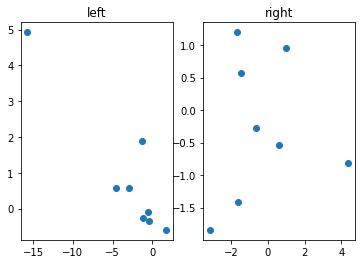

In [3]:
# visualize the synthetic data
fig, ax = plt.subplots(1, 2)

ax[0].set_title('left')
ax[0].scatter(*torch.chunk(dehomogenize_points(points_l), 2, dim=-1))
ax[1].set_title('right')
ax[1].scatter(*torch.chunk(dehomogenize_points(points_r), 2, dim=-1))

In [4]:
def get_fundamental_matrix(points_l, points_r):
    #raise NotImplementedError
    equations = torch.einsum('bi,bj->bij', points_r, points_l).view(-1, 9)
    u, s, v = torch.linalg.svd(equations)
    F = v[-1].view(3, 3)
    return F
    
def compute_residuals(F, points_l, points_r):
    #raise NotImplementedError
    return torch.einsum('bi,ij,bj->b', points_r, F, points_l)

def compute_errors(F, points_l, points_r):
    # optional
    raise NotImplementedError

In [5]:
F = get_fundamental_matrix(points_l, points_r)
residuals = compute_residuals(F, points_l, points_r)

print(residuals.abs().max())

tensor(4.7684e-07)


# Real Example

In [6]:
left = plt.imread('left.jpg')
right = plt.imread('right.jpg')
h, w, _ = left.shape  # same shape for left and right
# see https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html for details
correspondences = torch.load('correspondences.pt')
# points are in homogeneous coordinates, however z = 1 for all points
points_l = correspondences['points_l']
points_r = correspondences['points_r']

In [7]:
def plot_correspondences(ax, points_l, points_r, w):
    for point_l, point_r in zip(points_l, points_r):
        ax.plot([point_l[0], point_r[0] + w],
                [point_l[1], point_r[1]],
               marker='o')

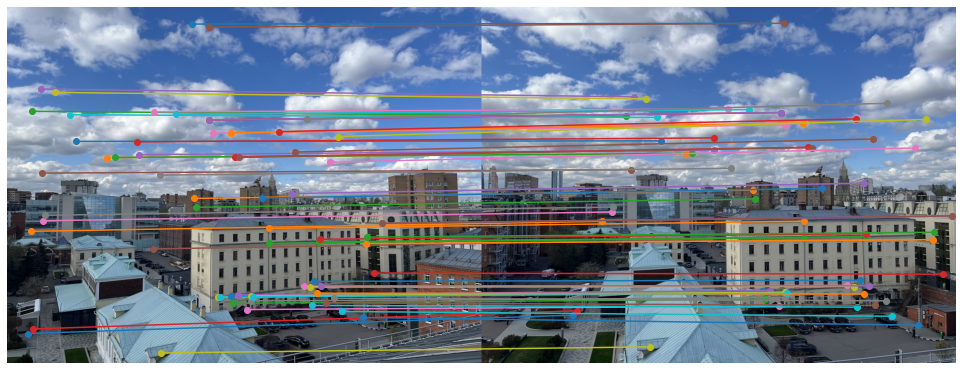

In [8]:
fig, ax = plt.subplots(figsize=(17, 10))
concatenated_image = np.concatenate((left, right), axis=1)
ax.imshow(concatenated_image)
plot_correspondences(ax, points_l, points_r, w)
ax.axis('off');

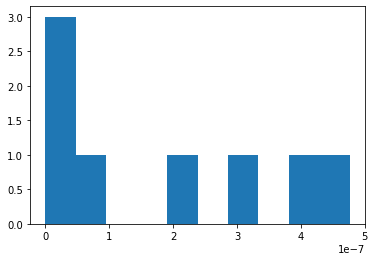

In [9]:
F = get_fundamental_matrix(points_l,
                           points_r)
resiudals = compute_residuals(F, points_l, points_r)
plt.hist(residuals.abs());

In [10]:
def plot_epipolar_lines(ax, F, point_l, point_r, w):
    # plot two epipolar lines for a single correspondence
    line_l = torch.einsum('ij,i->j', F, point_r)
    line_l_parametric = torch.tensor([line_l[1], -line_l[0]])
    line_l_parametric /= line_l_parametric.norm()
    line_r = torch.einsum('ij,j->i', F, point_l)
    line_r_parametric = torch.tensor([line_r[1], -line_r[0]])
    line_r_parametric /= line_r_parametric.norm()
    
    point_l = homogenize_points(point_l)
    point_r = homogenize_points(point_r)
    c = np.random.rand(1, 3)
    ax.scatter([point_l[0], point_r[0] + w],
               [point_l[1], point_r[1]],
               c=c)
    delta_t = -75
    # left line
    ax.plot([point_l[0] - delta_t * line_l_parametric[0], point_l[0] + delta_t * line_l_parametric[0]],
            [point_l[1] - delta_t * line_l_parametric[1], point_l[1] + delta_t * line_l_parametric[1]],
            c=c)
    # right line
    ax.plot([point_r[0] - delta_t * line_r_parametric[0] + w, point_r[0] + delta_t * line_r_parametric[0] + w],
            [point_r[1] - delta_t * line_r_parametric[1], point_r[1] + delta_t * line_r_parametric[1]],
            c=c)

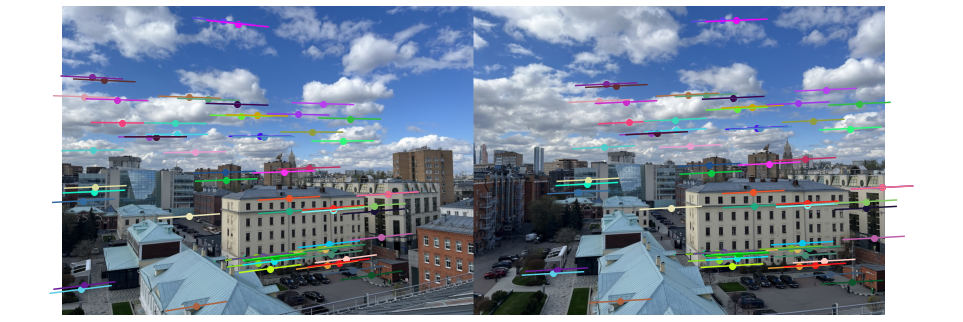

In [11]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.imshow(concatenated_image)
for point_l, point_r in zip(points_l, points_r):
    plot_epipolar_lines(ax, F, point_l, point_r, w)
ax.axis('off');

#plt.savefig('images_with_epipolar_lines.jpg', bbox_inches='tight', dpi=200)